In [2]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import random
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import re
import math
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

In [3]:
df = pd.read_csv("medium_articles.csv")

In [4]:
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

In [5]:
articles = df.text.values[:1000]

In [6]:
def tfidf_embeddings(texts):
    vectorizer = TfidfVectorizer(max_features=500)
    return vectorizer.fit_transform(texts).toarray()

def distilbert_cls_embeddings(texts):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :] 
        embeddings.append(cls_embedding.squeeze().numpy())
    return np.array(embeddings)

def sentence_transformer_embeddings(texts):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    return model.encode(texts, show_progress_bar=False)

embedding_methods = {
    "DistilBERT CLS": distilbert_cls_embeddings,
    "TF-IDF": tfidf_embeddings,
    "Sentence Transformer": sentence_transformer_embeddings
}

In [41]:
# clustered_articles = {i: [] for i in range(num_clusters)}
# for article, label in zip(articles, labels):
#     clustered_articles[label].append(article)

# for cluster_idx, articles in clustered_articles.items():
#     print(f"\nCluster {cluster_idx}:\n")
#     for article in articles[:3]: 
#         print(f"- {article}")

In [56]:
# startup_articles = df[df.tags=="['Startup']"]['text']

In [11]:
# embeddings = get_cls_embeddings(startup_articles)
# cluster_analysis(embeddings)

In [31]:
# results = {}
# for name, embedding_func in embedding_methods.items():
#     print(f"Generating embeddings using {name}...")
#     embeddings = embedding_func(articles)
    
#     print(f"Applying t-SNE for {name} embeddings...")
#     tsne = TSNE(n_components=2, perplexity=30, random_state=1)
#     tsne_embeddings = tsne.fit_transform(embeddings)

#     num_clusters = 5 
#     kmeans = KMeans(n_clusters=num_clusters, random_state=1)
#     labels = kmeans.fit_predict(embeddings)
    
#     plt.figure(figsize=(8, 6))
#     palette = sns.color_palette("tab10", max(labels) + 1)
#     for cluster_idx in range(max(labels) + 1):
#         cluster_points = tsne_embeddings[labels == cluster_idx]
#         plt.scatter(
#             cluster_points[:, 0], cluster_points[:, 1],
#             s=50, label=f"Cluster {cluster_idx}", alpha=0.7, color=palette[cluster_idx]
#         )
#     plt.title(f"{name} Clustering")
#     plt.xlabel("t-SNE Dimension 1")
#     plt.ylabel("t-SNE Dimension 2")
#     plt.legend()
#     plt.show()

In [17]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
import hdbscan
from sklearn.metrics import pairwise_distances
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


clustering_hyperparams = {
    "KMeans": {
        "n_clusters": [3, 5, 7, 10],
    },
    "Agglomerative": {
        "n_clusters": [3, 5, 7, 10],
        "linkage": ["ward", "complete", "average"],
    },
    "Spectral": {
        "n_clusters": [3, 5, 7, 10],
        "affinity": ["nearest_neighbors", "rbf"],
    },
    "Gaussian Mixture": {
        "n_components": [3, 5, 7, 10],
        "covariance_type": ["full", "tied", "diag", "spherical"],
    },
}

def tune_clustering(algorithm_name, embeddings, params):
    print(f"Tuning {algorithm_name}")
    best_score = -1
    best_params = None
    best_labels = None

    for param_combination in ParameterGrid(params):
        if algorithm_name == "KMeans":
            model = KMeans(**param_combination, random_state=1)
        elif algorithm_name == "Agglomerative":
            model = AgglomerativeClustering(**param_combination)
        elif algorithm_name == "Spectral":
            model = SpectralClustering(**param_combination, random_state=1)
        elif algorithm_name == "Gaussian Mixture":
            model = GaussianMixture(**param_combination, random_state=1)
        try:
            if algorithm_name == "Gaussian Mixture":
                labels = model.fit_predict(embeddings)
            else:
                labels = model.fit(embeddings).labels_
        except Exception as e:
            print(f"Error with params {param_combination}: {e}")
            continue
            
        if len(set(labels)) > 1 and -1 not in labels:
            score = silhouette_score(embeddings, labels)
            if score > best_score:
                best_score = score
                best_params = param_combination
                best_labels = labels

    print(f"Best Params for {algorithm_name}: {best_params}, Best Score: {best_score}")
    return best_labels, best_params

In [18]:
def cluster_plot(embeddings, tsne_embeddings, algorithm_name, labels, params):
    print(f"Visualizing results for {algorithm_name} with params {params}")
    plt.figure(figsize=(8, 6))
    unique_labels = set(labels)
    palette = sns.color_palette("tab10", len(unique_labels) - (1 if -1 in unique_labels else 0))
    for cluster_idx in unique_labels:
        if cluster_idx == -1: 
            color = "gray"
            cluster_points = tsne_embeddings[labels == cluster_idx]
            plt.scatter(
                cluster_points[:, 0], cluster_points[:, 1],
                s=50, label="Noise", alpha=0.7, color=color
            )
        else:
            cluster_points = tsne_embeddings[labels == cluster_idx]
            plt.scatter(
                cluster_points[:, 0], cluster_points[:, 1],
                s=50, label=f"Cluster {cluster_idx}", alpha=0.7, color=palette[cluster_idx]
            )
    plt.title(f"{algorithm_name} Clustering")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

DistilBERT CLS embeddings
Applying t-SNE for dimensionality reduction
Tuning KMeans
Best Params for KMeans: {'n_clusters': 3}, Best Score: 0.10108790546655655
Visualizing results for DistilBERT CLS - KMeans with params {'n_clusters': 3}


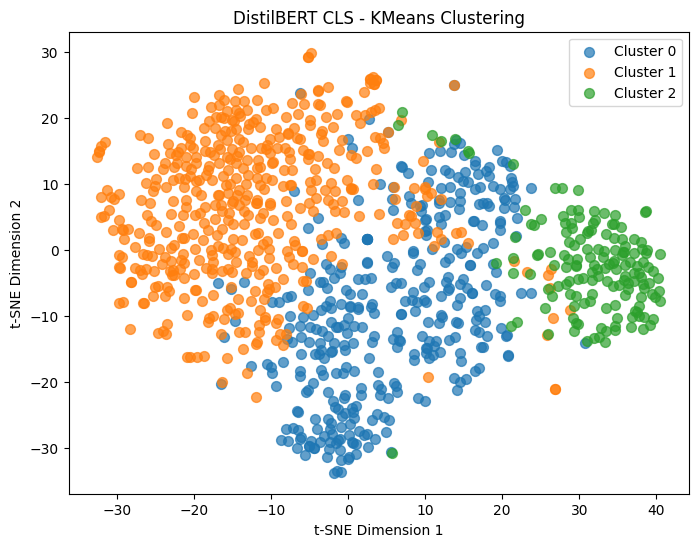

Tuning Agglomerative
Best Params for Agglomerative: {'linkage': 'average', 'n_clusters': 3}, Best Score: 0.16316565871238708
Visualizing results for DistilBERT CLS - Agglomerative with params {'linkage': 'average', 'n_clusters': 3}


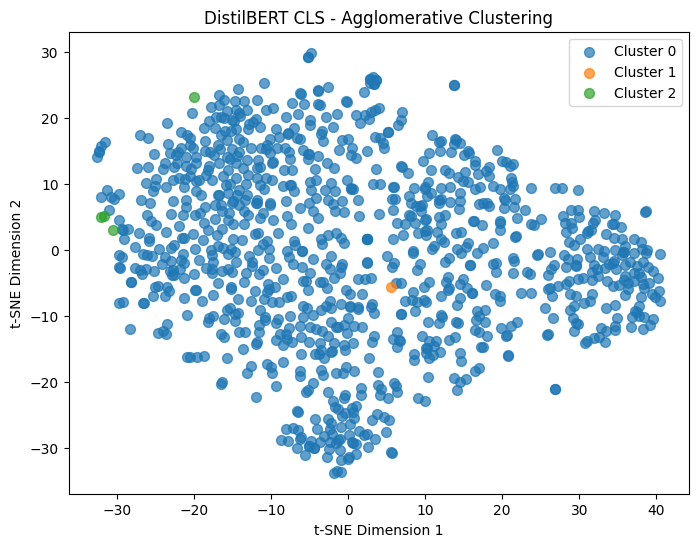

Tuning Spectral
Best Params for Spectral: {'affinity': 'nearest_neighbors', 'n_clusters': 5}, Best Score: 0.08317036926746368
Visualizing results for DistilBERT CLS - Spectral with params {'affinity': 'nearest_neighbors', 'n_clusters': 5}


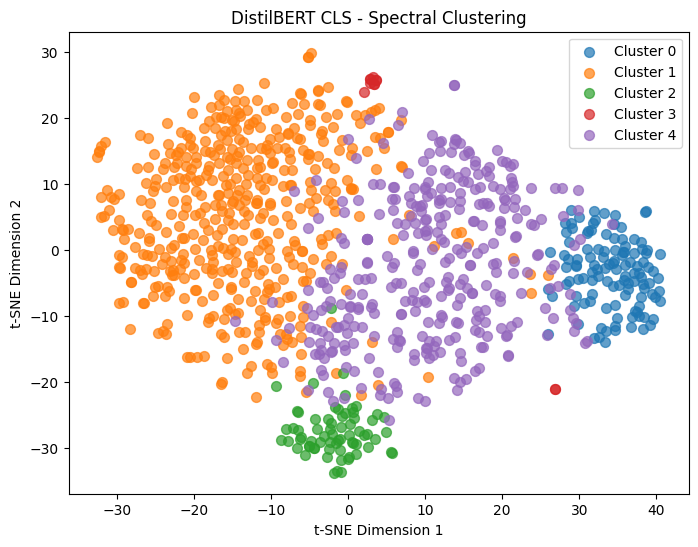

Tuning Gaussian Mixture
Best Params for Gaussian Mixture: {'covariance_type': 'full', 'n_components': 3}, Best Score: 0.10108790546655655
Visualizing results for DistilBERT CLS - Gaussian Mixture with params {'covariance_type': 'full', 'n_components': 3}


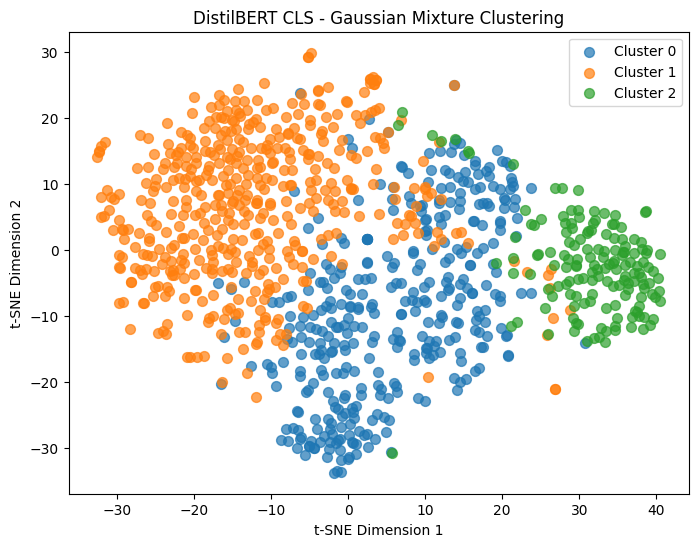

TF-IDF embeddings
Applying t-SNE for dimensionality reduction
Tuning KMeans
Best Params for KMeans: {'n_clusters': 3}, Best Score: 0.053193825389626026
Visualizing results for TF-IDF - KMeans with params {'n_clusters': 3}


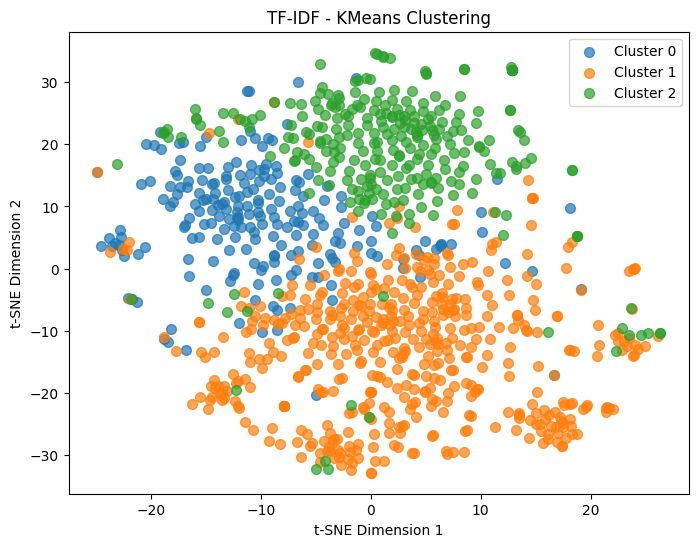

Tuning Agglomerative
Best Params for Agglomerative: {'linkage': 'average', 'n_clusters': 3}, Best Score: 0.18262147881300345
Visualizing results for TF-IDF - Agglomerative with params {'linkage': 'average', 'n_clusters': 3}


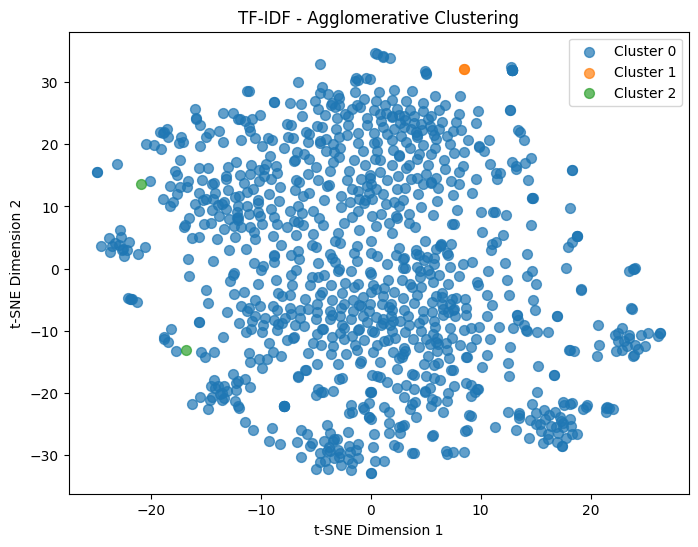

Tuning Spectral
Best Params for Spectral: {'affinity': 'nearest_neighbors', 'n_clusters': 10}, Best Score: 0.041732963755399116
Visualizing results for TF-IDF - Spectral with params {'affinity': 'nearest_neighbors', 'n_clusters': 10}


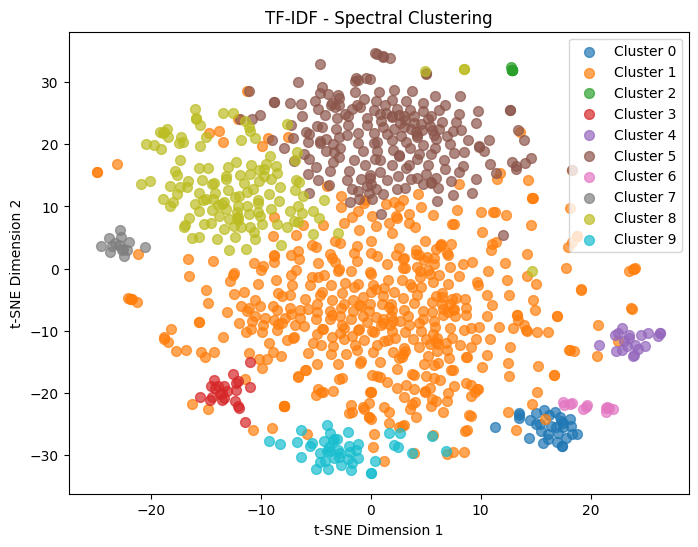

Tuning Gaussian Mixture
Best Params for Gaussian Mixture: {'covariance_type': 'full', 'n_components': 3}, Best Score: 0.053193825389626026
Visualizing results for TF-IDF - Gaussian Mixture with params {'covariance_type': 'full', 'n_components': 3}


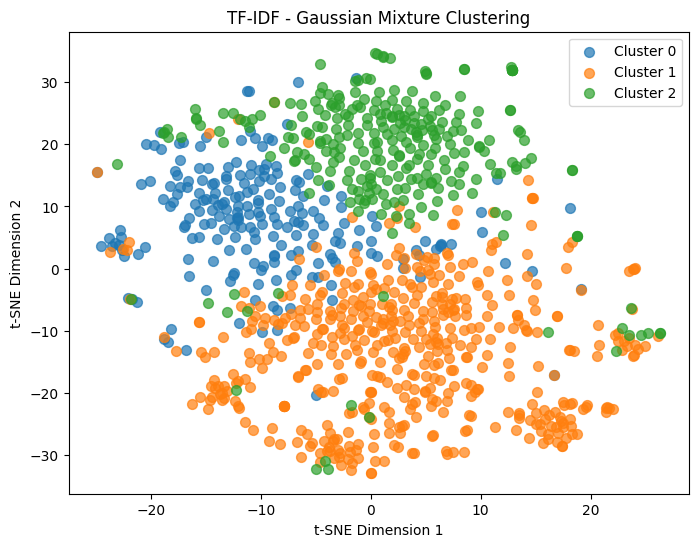

Sentence Transformer embeddings
Applying t-SNE for dimensionality reduction
Tuning KMeans
Best Params for KMeans: {'n_clusters': 3}, Best Score: 0.04069441929459572
Visualizing results for Sentence Transformer - KMeans with params {'n_clusters': 3}


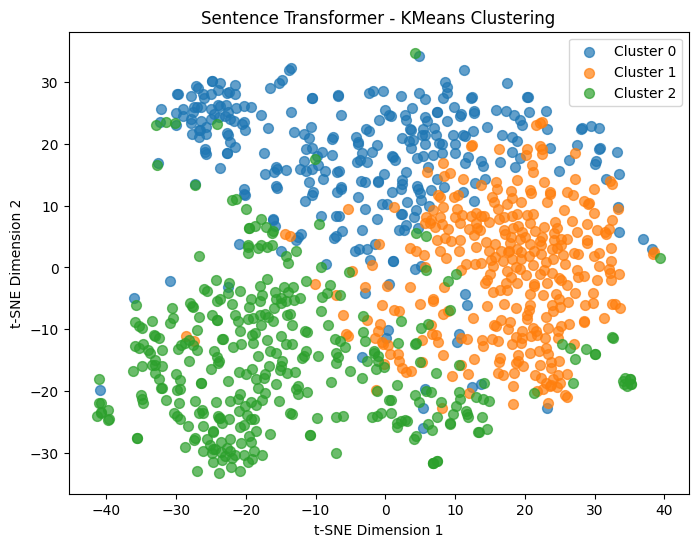

Tuning Agglomerative
Best Params for Agglomerative: {'linkage': 'average', 'n_clusters': 3}, Best Score: 0.04203791171312332
Visualizing results for Sentence Transformer - Agglomerative with params {'linkage': 'average', 'n_clusters': 3}


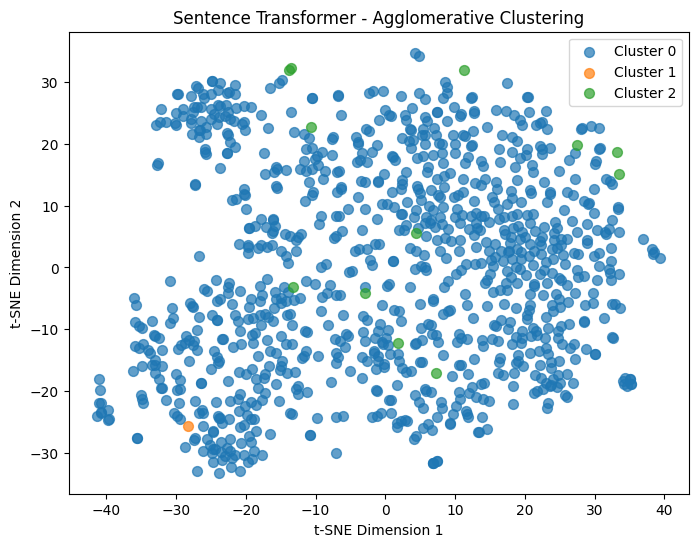

Tuning Spectral
Best Params for Spectral: {'affinity': 'nearest_neighbors', 'n_clusters': 3}, Best Score: 0.05606558918952942
Visualizing results for Sentence Transformer - Spectral with params {'affinity': 'nearest_neighbors', 'n_clusters': 3}


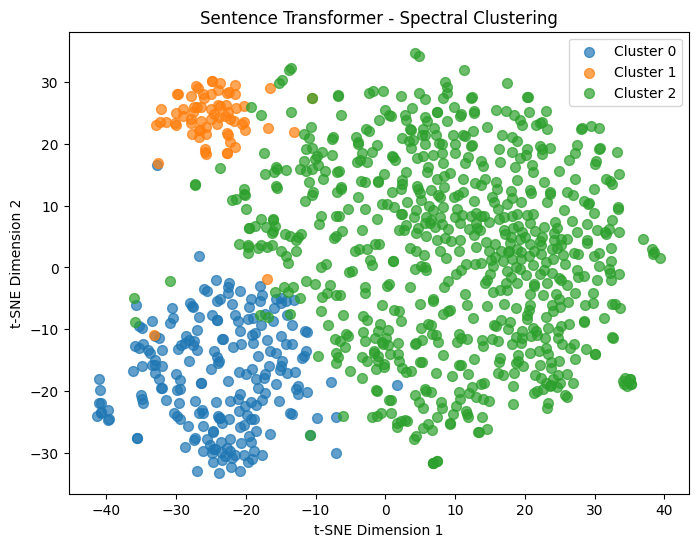

Tuning Gaussian Mixture
Best Params for Gaussian Mixture: {'covariance_type': 'full', 'n_components': 3}, Best Score: 0.04069441929459572
Visualizing results for Sentence Transformer - Gaussian Mixture with params {'covariance_type': 'full', 'n_components': 3}


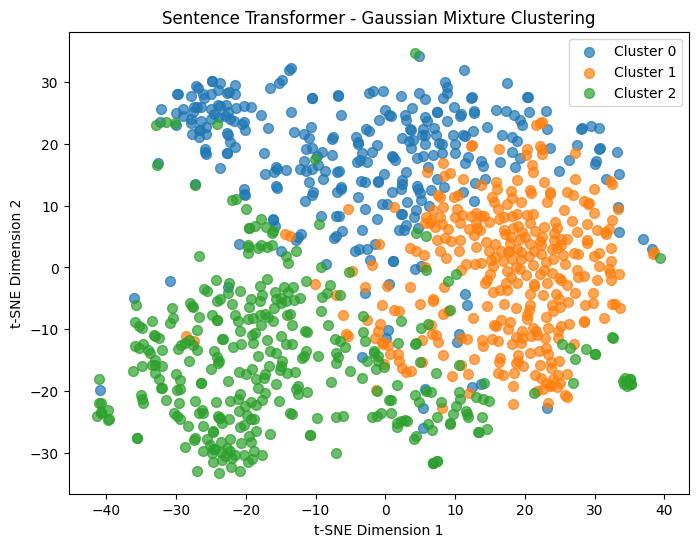

In [20]:
embedding_methods = {
    "DistilBERT CLS": distilbert_cls_embeddings,
    "TF-IDF": tfidf_embeddings,
    "Sentence Transformer": sentence_transformer_embeddings,
}
_ = []
# Process for each embedding method
for embedding_name, embedding_func in embedding_methods.items():
    print(f"{embedding_name} embeddings")
    embeddings = embedding_func(articles)

    print("Applying t-SNE for dimensionality reduction")
    tsne = TSNE(n_components=2, perplexity=30, random_state=1)
    tsne_embeddings = tsne.fit_transform(embeddings)

    for algo_name, params in clustering_hyperparams.items():
        labels, best_params = tune_clustering(algo_name, embeddings, params)
        if algo_name == 'Spectral':
            _.append([labels, best_params])
        if labels is not None: 
            cluster_plot(embeddings, tsne_embeddings, f"{embedding_name} - {algo_name}", labels, best_params)


In [63]:
# import numpy as np
# import hdbscan
# from sklearn.metrics import pairwise_distances

# def evaluate_hdbscan(embeddings, min_cluster_sizes, min_samples_list, cluster_selection_epsilons):
#     best_model = None
#     best_score = -np.inf
#     best_params = None
    
#     embeddings = embeddings.astype(np.float64)  

#     distance_matrix = pairwise_distances(embeddings, metric="cosine")

#     for min_cluster_size in min_cluster_sizes:
#         for min_samples in min_samples_list:
#             for eps in cluster_selection_epsilons:
#                 clusterer = hdbscan.HDBSCAN(cluster_selection_method='leaf',
#                     min_cluster_size=min_cluster_size,
#                     min_samples=min_samples,
#                     metric="precomputed", 
#                     cluster_selection_epsilon=eps
#                 )
#                 labels = clusterer.fit_predict(distance_matrix)

#                 num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#                 num_noise_points = np.sum(labels == -1)

#                 score = num_clusters - (num_noise_points * 0.1)

#                 if score > best_score:
#                     best_model = clusterer
#                     best_score = score
#                     best_params = {
#                         "min_cluster_size": min_cluster_size,
#                         "min_samples": min_samples,
#                         "cluster_selection_epsilon": eps
#                     }

#     return best_model, best_params

# min_cluster_sizes = [2, 3, 4, 5]
# min_samples_list = [10, 12, 15]
# cluster_selection_epsilons = [ 0.01, 0.02]


# best_hdbscan_model, best_hdbscan_params = evaluate_hdbscan(
#     embeddings, min_cluster_sizes, min_samples_list, cluster_selection_epsilons
# )

# labels_hdbscan = best_hdbscan_model.labels_
# print("Best Hyperparameters:", best_hdbscan_params)

Best Hyperparameters: {'min_cluster_size': 2, 'min_samples': 15, 'cluster_selection_epsilon': 0.01}


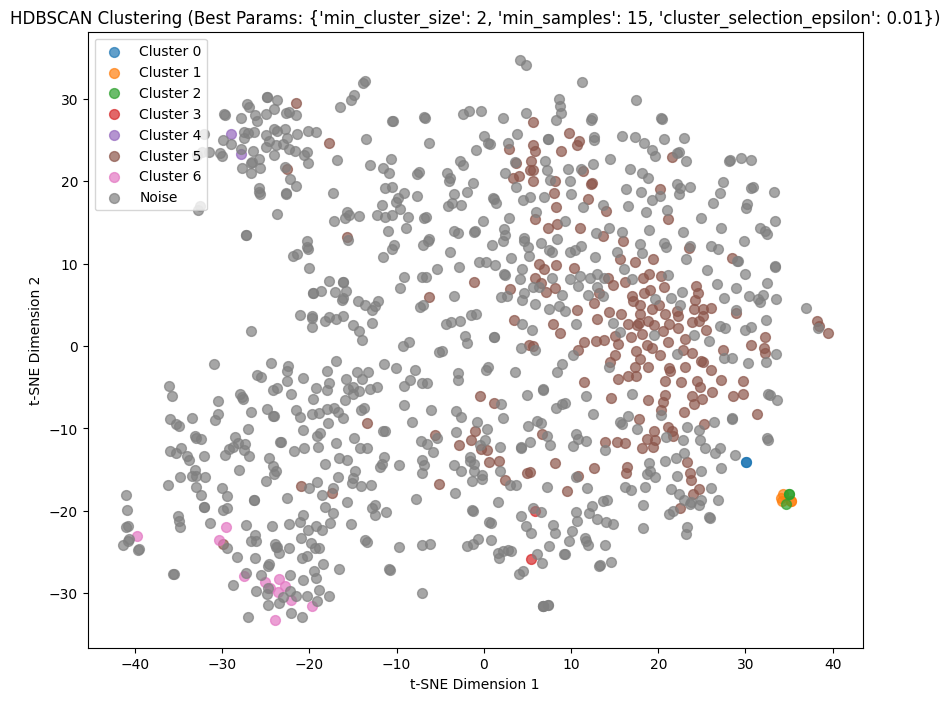

In [75]:

# plt.figure(figsize=(10, 8))
# unique_labels = set(labels_hdbscan)
# palette = sns.color_palette("tab10", len(unique_labels) + 1)

# for cluster_idx in unique_labels:
#     if cluster_idx == -1: 
#         cluster_points = tsne_embeddings[labels_hdbscan == cluster_idx]
#         plt.scatter(
#             cluster_points[:, 0], cluster_points[:, 1],
#             s=50, label="Noise", alpha=0.7, color="grey"
#         )
#     else: 
#         cluster_points = tsne_embeddings[labels_hdbscan == cluster_idx]
#         plt.scatter(
#             cluster_points[:, 0], cluster_points[:, 1],
#             s=50, label=f"Cluster {cluster_idx}", alpha=0.7, color=palette[cluster_idx]
#         )

# plt.title(f"HDBSCAN Clustering (Best Params: {best_hdbscan_params})")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.legend()
# plt.show()


Silhouette Score: 0.05606558918952942


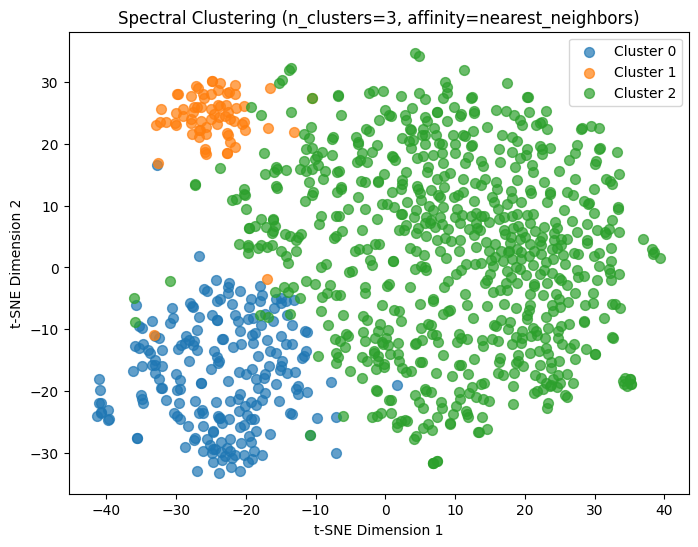

Storing clusters in Neo4j database


In [27]:
from neo4j import GraphDatabase
import uuid

class Neo4jManager:
    def __init__(self, uri, user=None, password=None):
        if user and password:
            self._driver = GraphDatabase.driver(uri, auth=(user, password))
        else:
            self._driver = GraphDatabase.driver(uri)

    def close(self):
        self._driver.close()

    def clear_database(self):
        with self._driver.session() as session:
            session.write_transaction(self._delete_all_nodes)

    @staticmethod
    def _delete_all_nodes(tx):
        query = "MATCH (n) DETACH DELETE n"
        tx.run(query)

    def add_article(self, content, cluster_label):
        with self._driver.session() as session:
            return session.write_transaction(self._merge_article_node, content, cluster_label)

    @staticmethod
    def _merge_article_node(tx, content, cluster_label):
        article_uuid = str(uuid.uuid4())
        query = (
            "MERGE (a:Article {content: $content}) "
            "ON CREATE SET a.cluster = $cluster, a.uuid = $uuid "
            "RETURN a.uuid AS article_uuid"
        )
        result = tx.run(query, content=content, cluster=cluster_label, uuid=article_uuid)
        return result.single()["article_uuid"]

    def create_relationships(self, cluster_articles):
        with self._driver.session() as session:
            for cluster, articles in cluster_articles.items():
                for i in range(len(articles)):
                    for j in range(i + 1, len(articles)):
                        session.write_transaction(
                            self._create_relationship,
                            articles[i],
                            articles[j]
                        )

    @staticmethod
    def _create_relationship(tx, article1, article2):
        query = (
            "MATCH (a:Article {uuid: $article1}), (b:Article {uuid: $article2}) "
            "MERGE (a)-[:SAME_CLUSTER]->(b)"
        )
        tx.run(query, article1=article1, article2=article2)


# Initialize Neo4jManager
uri = "bolt://localhost:7687"
neo4j_manager = Neo4jManager(uri, '', '')

def neo4j_cluster(articles, labels):
    cluster_articles = {}
    for article, label in zip(articles, labels):
        article_uuid = neo4j_manager.add_article(content=article, cluster_label=label)
        if label not in cluster_articles:
            cluster_articles[label] = []
        cluster_articles[label].append(article_uuid)
    neo4j_manager.create_relationships(cluster_articles)

def spectral_clustering(articles, embeddings, n_clusters, affinity="rbf"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=1)
    tsne_embeddings = tsne.fit_transform(embeddings)
    spectral_model = SpectralClustering(n_clusters=n_clusters, affinity=affinity, random_state=1)
    labels = spectral_model.fit_predict(embeddings)
    silhouette = silhouette_score(embeddings, labels)
    print(f"Silhouette Score: {silhouette}")

    plt.figure(figsize=(8, 6))
    unique_labels = set(labels)
    palette = sns.color_palette("tab10", len(unique_labels))
    for cluster_idx in unique_labels:
        cluster_points = tsne_embeddings[labels == cluster_idx]
        plt.scatter(
            cluster_points[:, 0], cluster_points[:, 1],
            s=50, label=f"Cluster {cluster_idx}", alpha=0.7, color=palette[cluster_idx]
        )
    plt.title(f"Spectral Clustering (n_clusters={n_clusters}, affinity={affinity})")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

    return labels

def neo4j_store(articles, labels, neo4j_uri):
    print("Storing clusters in Neo4j database")
    neo4j_manager = Neo4jManager(neo4j_uri)

    cluster_articles = {}
    for article, cluster_label in zip(articles, labels):
        article_uuid = neo4j_manager.add_article(article, cluster_label)
        if cluster_label not in cluster_articles:
            cluster_articles[cluster_label] = []
        cluster_articles[cluster_label].append(article_uuid)

    neo4j_manager.create_relationships(cluster_articles)
    neo4j_manager.close()

neo4j_manager = Neo4jManager(uri="bolt://localhost:7687", user="", password="")
neo4j_manager.clear_database()

embeddings = sentence_transformer_embeddings(articles)
labels = spectral_clustering(articles, embeddings, n_clusters=3, affinity="nearest_neighbors")
neo4j_store(articles, labels, "bolt://localhost:7687")